In [1]:
from lenskit.metrics import dataGenerator
from lenskit import batch, topn, util, topnFair
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn, topnFair

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
#ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
#                      names=['user', 'item', 'rating', 'timestamp'], header=0)

#items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
#                      names=['movieId','title','genres'], header=0)

ratings = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)

items = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['item','title','genres'], header=0)

#C:\Users\josse\Git-kode projects\Speciale\Fair-Recommendations\ml-latest-small\ratings.csv

In [4]:
#items

In [5]:
items_dummy = pd.concat([items, items['genres'].str.get_dummies(sep='|')], axis=1)
items_dummy.head()

,item,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

In [7]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [8]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 1, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))
    

test _reccomend
test _reccomend


In [9]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs_joined = all_recs.join(items_dummy.set_index('item'), on='item')
all_recs_joined.head()

,item,score,user,rank,Algorithm,title,genres,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,356,3.729167,1,1,ItemItem,Forrest Gump (1994),Comedy|Drama|Romance|War,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,349,3.562500,1,2,ItemItem,Clear and Present Danger (1994),Action|Crime|Drama|Thriller,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1022,3.562500,1,3,ItemItem,Cinderella (1950),Animation|Children|Fantasy|Musical|Romance,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,480,3.562500,1,4,ItemItem,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,0,1,1,...,0,0,0,0,0,0,1,1,0,0
4,1968,3.562500,1,5,ItemItem,"Breakfast Club, The (1985)",Comedy|Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,1,1172,4.0
1,1,1343,2.0
2,1,1405,1.0
3,1,1029,3.0
4,2,356,3.0


In [11]:
#all_recs_joined['item'].values

In [12]:
_protected_group2 = all_recs_joined.loc[all_recs_joined['Action'] == 1]
_protected_group2.head()
_protected_group2['item'].values

array([  349,   480,  2716,  5349,  1544,   377,  1953,  5349,  2716,
        1544,  2193,   349,   480,  1953,  1544,  2193,  5349,   377,
         480,   349,  1953,  2716,  2193,  1197,  2959,  1544,  2115,
        2194,  1210,  1208,  2406,  1387,  1396,  1580,  1858,  1240,
        2000,  1220,  2005,  1196,   260,  2991,   541,  2959,  1197,
        2616,  1918,  3208,   173,  1377,  2002,   380,  1544,  2028,
        1378,    10,   367,   434,   442,   610,  2409,  2403,  2094,
        1356,  1374,  1917,  3104,  2916,  2683,  1240,  1858,   480,
         349,  1953,   153,  1387,  1396,  1580,  1858,  2000,  2005,
        1127,  1196,  1208,  1210,  1220,  1240,   541,  2115,  2406,
         112,  2991,   260,  2959,   405,   474,  2028,  1378,  2273,
       33679,  6502, 41569,  8644,   168,   208,   552, 44191,   736,
        2716,  1240,  2115,  1220,  2194,  1208,  1858,  1396,  1387,
        2000,  2005,  1210,  1580,  2991,   541,   260,   112,  1196,
        2628,  2640,

In [17]:
# user , algorithms = iput to group_cols --> de koloner der skal  groupes på 
rla = topnFair.FairRecListAnalysis(['user', 'Algorithm'])
rla.add_metric("rND")
rla.add_metric("rKL")
rla.add_metric("rRD")
results = rla.compute(all_recs_joined, test_data)
results.head()

rND       rKL       rRD
user Algorithm                              
1    ALS        0.110558  0.063544  0.152859
     ItemItem   0.031453  0.007581  0.053193
2    ALS        0.065420  0.011094  0.000000
     ItemItem   0.043360  0.030218  0.064237
3    ALS        0.090154  0.036402  0.131961

In [16]:
results.groupby('Algorithm').rND.mean()

Algorithm
ALS         0.089362
ItemItem    0.018977
Name: rND, dtype: float64

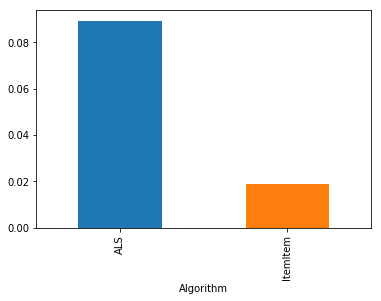

In [15]:
results.groupby('Algorithm').rND.mean().plot.bar()